In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from tqdm import tqdm
from collections import defaultdict
import random
import matplotlib.pyplot as plt


A move is represented as an integer like that

0 | 1 | 2  \
--+---+--  \
3 | 4 | 5  \
--+---+--  \
6 | 7 | 8

In [20]:
def tuple_to_int(action):
    return action[0] * 3 + action[1]

def int_to_tuple(position):
    return (int(position/3), position % 3)

I think we should make a Player class similar to OptimalPlayer. Basically we modify the 'act' function for different learning algorithms.
It should look something like that below

A couple of observations:
 - In order to perform a Q-learning step, we need a future state action pair, but we have an opponent, so we cannot just look into future states, we need to consider the move of our opponent. One way to do it is to assume that our opponent is part of the environment and simulate its move as a 'random move' and consider directly the state after (that is reasonable to me so that's what I implemented). 
 - An other option is to directly use its optimal move strategy, it might result in better training but it feels like cheating: in real life you don't have access to your opponents 'best move'. Does this makes sense?
 - A third option is to first play a move, wait for the opponent to make his move and then update the q-values at the end. Maybe this is the most logical

 - My other problem wast that if we consider state-action pairs the number of q-values are getting out of hands quickly we have 3^9 states and possibly at most 9 action for each state. The state graph is also reproducing in a sense that you can reach the same board position from different configurations. If we just consider so called 'after states' we could reduce the number of parameters. I tried this approach with my functions actV and updateV, but this is not necessarily-learning anymore (rather TD(0))

 

The code is really messy sorry for that, I hate using notebooks but i didn't want to modify the env file so i just copied everything here i needed

In [64]:
class QPlayer:
    def __init__(self, epsilon=0.2, alpha=0.05, gamma=0.99, player='X'):
        self.epsilon = epsilon
        self.player = player # 'x' or 'O'
        self.alpha = alpha
        self.gamma = gamma
        # 3^9 states 9 length vectors are keys and 9 length list of values represents actions 
        self.Qvalues = defaultdict(lambda: [0 for _ in range(9)]) 
        self.Vvalues = defaultdict(int)
        self.current_action = None
        self.opponent = {'X', 'O'} - set(self.player)
        self.player2value = {'X': 1, 'O': -1}

    def get_opponent(self):
        return list({'X', 'O'} - set(self.player))[0]

    def empty(self, grid):
        '''return all empty positions'''
        avail = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if grid[pos] == 0:
                avail.append(pos)
        return avail

    def randomMove(self, grid):
        """ Chose a random move from the available options. """
        avail = self.empty(grid)
        return avail[random.randint(0, len(avail)-1)]

    def act(self, grid):
        # epsilon greedy policy
        if random.random() < self.epsilon:
            action = self.randomMove(grid)
        else:
            idx = np.argmax([self.Qvalues[str(grid)][tuple_to_int(pos)] for pos in self.empty(grid)])
            action = self.empty(grid)[idx]
        self.current_action = tuple_to_int(action)    
        return action

    def actV(self, grid):
        # epsilon greedy policy
        if random.random() < self.epsilon:
            return self.randomMove(grid)
        else:
            future_states = []
            for pos in self.empty(grid):
                current = grid.copy()
                current[pos] = self.player2value[self.player]
                future_states.append(current)

        idx = np.argmax([self.Vvalues[str(state)] for state in future_states])
        self.current_action = self.empty(grid)[idx]   
        return self.current_action

    def updateQ(self, grid, end):
        if (end == True):
            reward = 1
            off_policy = 0
        else:
            reward = 0
            # simulate random opponent move
            opponent_action = self.randomMove(grid)
            grid[opponent_action] = self.player2value[self.get_opponent()]
            if np.count_nonzero(grid) == 9:
                off_policy = 0
            else:
                off_policy = max([self.Qvalues[str(grid)][tuple_to_int(pos)] for pos in self.empty(grid)])
        q = self.Qvalues[str(grid)][self.current_action] 
        self.Qvalues[str(grid)][self.current_action] = q + self.alpha * (reward + self.gamma * off_policy - q)

    def updateV(self,grid, end):
        if (end == True):
            reward = 1
            off_policy = 0
        else:
            reward = 0
            # simulate random opponent move
            opponent_action = self.randomMove(grid)
            grid[opponent_action] = self.player2value[self.get_opponent()]
            if np.count_nonzero(grid) == 9:
                off_policy = 0
            else:
                future_states = []
                for pos in self.empty(grid):
                    current = grid.copy()
                    current[pos] = self.player2value[self.player]
                    future_states.append(current)

                off_policy = max([self.Vvalues[str(state)] for state in future_states])
        v = self.Vvalues[str(grid)] 
        self.Vvalues[str(grid)] =  v + self.alpha * (reward + self.gamma * off_policy - v)

            


Helper function to evaluate games:

Our agent is agent1 and we are playing against agent2 (chosen to be random or optimal). The outer loop corresponds to the number of games, before each game we reset the environment and flip the player order. Whenever it is our turn we choose an action accoring to epsilon greedy strategy (see function act() and actV()) and then update the corresponding values (updateQ() or updateV()). Feel free to experiment with Q or V value calculations.

In [49]:
def simulate(agent1, agent2, N=500):
    env = TictactoeEnv()
    N_win = 0
    N_loose = 0
    history = []
    turns = np.array(['X','O'])
    flip = np.array([1,0])
    for i in tqdm(range(N)):
        # initialize env and players
        env.reset()
        grid, _, __ = env.observe()

        turns = turns[flip]
        agent1.player = turns[0]
        agent1.opponent = turns[1]
        agent2.player = turns[1]

        # simulation
        for j in range(9):
            if env.current_player == agent1.player:
                move = agent1.actV(grid)
                #move = agent1.act(grid)
                grid, end, winner = env.step(move, print_grid=False)
                agent1.updateV(grid.copy(), end)
                #agent1.update(grid.copy(), end)
            else:
                move = agent2.act(grid)
                grid, end, winner = env.step(move, print_grid=False)

            if end:
                # store results
                if winner == agent1.player:
                    N_win += 1
                    history.append(1)
                elif winner == agent2.player:
                    N_loose += 1
                    history.append(-1)
                else:
                    history.append(0)
                break
    return history, (N_win - N_loose) / N
            


Example run against half random agent. With terrible results

100%|██████████| 20000/20000 [02:58<00:00, 112.19it/s]

-0.1827


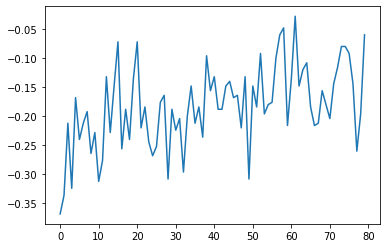

In [65]:
agent1 = QPlayer(epsilon=0.1)
agent2 = OptimalPlayer(epsilon=0.5)
history, metric = simulate(agent1, agent2, N=20000)
results = np.mean(np.array(history).reshape(80,250), axis=1)
print(metric)
plt.plot(results)

Example run against the random agent. It feels like it kind of learns and achieves a not-too-bad score

100%|██████████| 20000/20000 [02:30<00:00, 133.20it/s]

0.38625


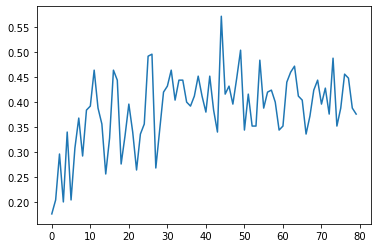

In [66]:
agent1 = QPlayer(epsilon=0.1)
agent2 = OptimalPlayer(epsilon=1)
history, metric = simulate(agent1, agent2, N=20000)
results = np.mean(np.array(history).reshape(80,250), axis=1)
print(metric)
plt.plot(results)